In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import rpy2
from rpy2.robjects import r
NULL = r("NULL")
import sys
sys.path.append('../') # Add one directory back to the path

from PFAS_DR import PFAS_DR

%load_ext watermark
%watermark -iv

R[write to console]: The mod.exe had been created.



matplotlib: 3.5.3
numpy     : 1.21.2
seaborn   : 0.11.2
pandas    : 1.5.2
rpy2      : 3.4.4
sys       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]



# Overview

Use the `PFAS_DR` class to simulate PFOS/PFOA single dose and repeat dose studies in adult animals.

A basic simulation uses a study-specific `dosing_dict`

```
final_metrics = [] # Initialize empty list
dosing_dict = {
    'chem': <chem>,       # 'PFOS' or 'PFOA'
    'ts': 0,              # Start simulation at conception
    'tf': 100,            # End of simulation (days)
    't_dose': 0.003,      # Oral gavage dose applied over ~5 minutes
    't_step':0.001,       # Time step for solver
    'sex': 'Male',        # Sex of animal. For PFOS in rats, this will always be male
    'M_m_1': 0.25,        # Body weight of animal during simulaiton (no growth)
    
    'strain': 'rat',            # Rat simulation, Can be monkey or mouse strain
    'sample_posterior': False,  # Don't sample posterior distributions
    'param_path': param_path,   # Path to the Rdata files with Wambaugh 2013 posteriors
    'model_path': model_path,   # Path to RMCSim model
    'dev': True,  
    
    't_m_start':0,             # Start maternal dosing at conception (GD0). Dosing can start before conception with t<0
    't_m_end': 100,            # End adult dosing on day 100
    'route': 'oral',           # Oral route of exposure
    'dose': 0,                 # 0 mg/kg dose for first dose
    'tm_daily_dose': [0],      # [0]: Once daily dosing, 'weekly': Once weekly dosing, None: Single dose
    
    'Qcc': 12.39,      # Qcc for rats from Wambaugh et al.

}
```

For the first dose, use the `dosing_dict` to initialize parameters, including dose, and run a simulation. Once the simulaiton is complete, store the appropriate internal dose metrics.
```
test_PFOS = PFAS_DR(**dosing_dict) # Initialize PFAS_DR class
test_PFOS.run_model() # Run the model using the dose_dict parameters
test_PFOS.plot_time_course(linestyle='-', color='blue', label_style='dose') #Optional: Plot simulation
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics)) # Append the desired dev_metrics
```

For remaining doses in a study, use `update_p` to update the appropriate simulation paramters. Any paramters not updated will remain the same as the previous simulation. Here, we update the dose to 0.3 mg/kg and change the materinal masses.

```
test_PFOS.update_p(dose=0.3, M_m_1=0.267, M_m_2=0.363) # Update parameters for next dosing scenario
test_PFOS.run_model() # Run the model with updated parameters
test_PFOS.plot_time_course(linestyle='-', color='cyan', label_style='dose') # Optional: plot new simulation
final_metrics.append(test_PFOS.get_internal_dose_metrics(dev_metrics)) # Append the desured dev_metrics
```

After including all dosing scenarios, `final_metrics` will the internal dose metric for each external dose

The function `parse_row` creates `dosing_dict` for each study


# Compile the model

Only have to run this cell once and only if model is currently not compiled in working directory

In [3]:
model_path = '../pfoa_2compabandersenoral_1cmptDev'
model_compile = PFAS_DR()
model_compile.pk_run.compile_pfas_model(model_path)

# Utility code

In [2]:
tox = pd.read_excel('../HECD 4-16 PFOA PFOS PBPK Data Needs - Update with Butenhoff Study_09.28.2021.xlsx', sheet_name=1)
n_studies = tox['HERO ID'].unique().shape[0]
n_designs = tox['Study Design'].unique().shape[0]
print('There are %s tox studies'%n_studies)
print('There are %s study designs:'%n_designs)
print(tox['Study Design'].unique())

There are 57 tox studies
There are 6 study designs:
['Developmental' '1-generation reproductive' 'Chronic (>90 days)'
 'Reproductive' 'Subchronic (30-90 days)' 'Short-term (1-30 days)']


In [3]:
model_path = '../pfoa_2compabandersenoral_1cmptDev'
param_path = '../data_files'

In [4]:
def parse_row(row, sample_posterior=False):
    """Parse information from the ICF row and return dictionary for modeling"""
    
    # Dictionaries for values
    species = row['Species'].lower()
    strain_dict = {'C57Bl/6': 'C57B6', 'CD-1': 'CD1', 'C57': 'C57B6', 'C57BL/6J': 'C57B6', 
                   
                   # Strain assumptions for non-CD1 mice
                   #------------------------
                   ' BALB/c': 'CD1', 'ICR': 'CD1', 'BALB/c': 'CD1', 'C57BL/6n': 'CD1', 'Crl:CD-1(ICR)BR':'CD1'
                   #------------------------
                  
                  }
    if species in ['monkey', 'rat']:
        strain = species
    else:
        strain = strain_dict[row['Strain']]
    
    # kg bodyweight defaults for each species
    BW_defaults = {'monkey': {'Male': 3.42,
                              'Female': 3.42},
                   'mouse': {'Male': 0.02,
                           'Female': 0.02},
                   'rat': {'Female': 0.203,
                           'Male': 0.222}
                  }
    Qcc = {'monkey': 19.8, 'mouse': 8.68, 'rat': 12.39}
    
    study_length = {'2wk': 2*7,
                    '26 wk': 26*7,
                    '5wk': 5*7,
                     '49d': 49,
                    '5 weeks': 5*7,
                    '30 days': 30,
                    '4wk': 4*7,
                    '28d': 28,
                    '4wk (1dose/d)': 4*7,
                    '28d (1dose/d)': 28,
                    '28 days': 28,
                    '28 Days': 28,
                    '26wk': 26*7,
                    '14wk': 14*7,
                    '26wk': 26*7,
                    '1y': 365,
                    '2y': 2*365,
                    '13wk': 13*7,
                    '15d': 15,
                    '10d': 10,
                    '4wk': 4*7,
                    '21d': 21,
                    '29d': 29,
                   }
    exposure_regimes = {'6m (1 dose/d)': 26*7,
                        'Daily in drinking water for 5 weeks': 5*7,
                        '7wk (1 dose/d)': 7*7,
                        '5wk (1 dose/d)': 5*7,
                        '30d (1 dose/d)': 30,
                        '28 d (1 dose/d)': 28,
                        '28d (1 dose/d)': 28,
                        '4wk (1 dose/d)': 4*7,
                        'Daily in feed for 14wk ': 14*7,
                        '26wk (1 dose/d)': 26*7,
                        'Daily in feed for 1y': 365,
                        'Daily in feed for 2y': 2*365,
                        'Daily in feed for 13wk': 13*7,
                        'Daily in drinking water for 15d after 10d of acclimation': 15,
                        'Daily through oral gavage for 15d after 10d of acclimation': 15,
                        'Daily through oral gavage for 10d after 10d of acclimation': 10,
                        'Daily in feed for 4wk ': 4*7,
                        '21d (1 dose/day)': 21,
                        '29d (1 dose/d)': 29,
                        'Daily in feed for 104wk': 2*365,
                        'Daily in feed for 103wk': 2*365,
                        

    }
    
    full_day_dose = ['Daily in drinking water for 5 weeks', 'Daily in feed for 14wk ', 
                     'Daily in feed for 1y', 'Daily in feed for 2y', 'Daily in feed for 13wk', 
                     'Daily in drinking water for 15d after 10d of acclimation', 'Daily in feed for 4wk ',
                    'Daily in feed for 104wk', 'Daily in feed for 103wk']
    
    sex = row['Sex']
    
    # ASSUMPTION
    #-----------
    if sex == 'Combined' or sex == 'Not reported':
        sex = 'Female'
    elif sex == 'Male' and strain == 'CD1' and row['PFOA/PFOS'] == 'PFOA':
        # Don't have male parameters for CD1 mice with PFOA
        sex = 'Female'
    elif sex == 'Female' and strain == 'rat' and row['PFOA/PFOS'] == 'PFOS':
        # Female rat PFOS parameters from Wambaugh do not adequately fit data while Male parameters do
        sex = 'Male'
    #-----------
    
    
    BW_meas = row['Body Weight at Study Termination (g)']
    BW_start = row['Body Weight at Start (g)']
    
    if not isinstance(BW_meas, str):
        BW = BW_meas/1000 # g --> kg
    elif BW_meas == 'NR':
        if not isinstance(BW_start, str):
            BW = BW_start/1000 # g --> kg
        elif BW_start == 'NR':
            BW = BW_defaults[species][sex]
        else:
            BW = np.mean([float(x) for x in BW_start.split('-')])/1000 # For reported ranges
    else:
        BW = BW_defaults[species][sex]
    
    
    dosing_dict = {}
    
    # Fill it in...
    dosing_dict['chem'] = row['PFOA/PFOS']
    dosing_dict['sex'] = sex
    dosing_dict['strain'] = strain
    dosing_dict['M_m_1'] = BW
    dosing_dict['Qcc'] = Qcc[species]
    dosing_dict['route']= 'oral' # Default for now
    dosing_dict['sample_posterior'] = sample_posterior
    dosing_dict['dose'] = float(row['Dose\n(mg/kg-day)'])#+0.01
    dosing_dict['tf'] = study_length[row['Length']]
    dosing_dict['ts'] = -1
    
    # Default daily dosing until need to change it
    #dosing_dict['sim_days'] = 'daily'
    #dosing_dict['sim_days'] = exposure_regimes[row['Exposure Regime']]
    #dosing_dict['tz_daily'] = np.array([0])
    dosing_dict['t_m_start'] = 0
    dosing_dict['t_m_end'] = exposure_regimes[row['Exposure Regime']]
    dosing_dict['tm_daily_dose'] = [0]
    dosing_dict['dev'] = False
    
    if row['Exposure Regime'] in full_day_dose:
        dosing_dict['t_dose'] = 1
    else:
        dosing_dict['t_dose'] = 0.0035 # 5 minute gavage
    
    # Paths
    dosing_dict['parm_path'] = param_path
    dosing_dict['model_path'] = model_path
    
    return dosing_dict
    
    

# Example study

Run through dose metric for given hero_id

Running adult model for CD1 with 0.0 mg/kg PFOA
Cavg     0.0
C7avg    0.0
AUC      0.0
Name: 0.0 mg/kg, dtype: float64
Running adult model for CD1 with 0.3 mg/kg PFOA
Cavg      17.282879
C7avg     27.718274
AUC      519.320975
Name: 0.3 mg/kg, dtype: float64
Running adult model for CD1 with 1.0 mg/kg PFOA
Cavg       49.036980
C7avg      70.504780
AUC      1475.239736
Name: 1.0 mg/kg, dtype: float64
Running adult model for CD1 with 10.0 mg/kg PFOA
Cavg      111.604515
C7avg     119.160916
AUC      3417.118384
Name: 10.0 mg/kg, dtype: float64
Running adult model for CD1 with 30.0 mg/kg PFOA
Cavg      151.774109
C7avg     158.944821
AUC      4767.925992
Name: 30.0 mg/kg, dtype: float64
Running adult model for rat with 0.0 mg/kg PFOA
Cavg     0.0
C7avg    0.0
AUC      0.0
Name: 0.0 mg/kg, dtype: float64
Running adult model for rat with 0.3 mg/kg PFOA
Cavg      13.294131
C7avg     19.137082
AUC      398.907780
Name: 0.3 mg/kg, dtype: float64
Running adult model for rat with 1.0 mg/kg PFOA
C

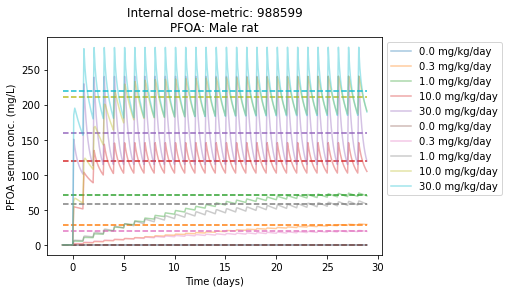

In [5]:
hero_id = 988599 # Any HERO ID from tox dataframe
tmp_study = tox[tox['HERO ID'] == hero_id]
sex = tmp_study['Sex'].unique()
for s in sex:
    study = tmp_study[tmp_study['Sex'] == s]
    n_doses = len(study['Dose\n(mg/kg-day)'])
    PFAS = PFAS_DR()
    my_colors = cm.get_cmap('tab10', n_doses)
    j = 0
    for i, row in study.iterrows():
        dosing_dict = parse_row(row)
        if dosing_dict['chem'] == 'PFOA' and dosing_dict['sex'] == 'Male' and dosing_dict['strain'] == 'CD1':
            print('No parameters for PFOA in Male CD1 Mice')
            continue

        if dosing_dict['chem'] == 'PFOS' and dosing_dict['strain'] == 'C57B6':
            # We don't have PFOS data for C57B6 so assume CD1 for now
            dosing_dict['strain'] = 'CD1'
        #print(dosing_dict)
        PFAS.update_p(**dosing_dict)
        #dosing_dict['disp_params'] = True
        PFAS.run_model()
        PFAS.plot_time_course(color=my_colors.colors[j], disp_mean=True, alpha=0.4, label_style='dose') # disp_mean plots horizontal line at Clast7
        print(PFAS.get_internal_dose_metrics(['Cavg', 'C7avg', 'AUC']))
        j+=1
    PFAS.ax[0].set_title('Internal dose-metric: %s\n%s: %s %s' % (row['HERO ID'], dosing_dict['chem'], dosing_dict['sex'],  dosing_dict['strain']))

In [5]:
writer = pd.ExcelWriter('internal_dose_metrics_nonDev_FINAL.xlsx', engine='xlsxwriter')

In [6]:
all_metrics = ['AUC', 'AUCavg', 'Cmax', 'Cavg', 'C7avg']

# Chronic (>90 days)

Calculate dose metrics for the chronic studies

In [7]:
chronic = tox[tox['Study Design'] == 'Chronic (>90 days)']
chronic = chronic[~chronic['HERO ID'].isin([7330145])]
print('Hero IDs to calculate:')
print(chronic['HERO ID'].unique().tolist())
chronic_hero_ids = chronic['HERO ID'].unique().tolist()

Hero IDs to calculate:
[6320656, 1290852, 757853, 2919192, 1276144]


6320656
Running adult model for monkey with 0.0 mg/kg PFOA
Running adult model for monkey with 3.0 mg/kg PFOA
Running adult model for monkey with 10.0 mg/kg PFOA
Running adult model for monkey with 20.0 mg/kg PFOA
1290852
Running adult model for rat with 0.0 mg/kg PFOS
Running adult model for rat with 0.03 mg/kg PFOS
Running adult model for rat with 0.13 mg/kg PFOS
Running adult model for rat with 0.34 mg/kg PFOS
Running adult model for rat with 1.33 mg/kg PFOS
Running adult model for rat with 0.0 mg/kg PFOS
Running adult model for rat with 0.04 mg/kg PFOS
Running adult model for rat with 0.15 mg/kg PFOS
Running adult model for rat with 0.4 mg/kg PFOS
Running adult model for rat with 1.56 mg/kg PFOS
757853
Running adult model for monkey with 0.0 mg/kg PFOS
Running adult model for monkey with 0.03 mg/kg PFOS
Running adult model for monkey with 0.15 mg/kg PFOS
Running adult model for monkey with 0.75 mg/kg PFOS
Running adult model for monkey with 0.0 mg/kg PFOS
Running adult model for mo

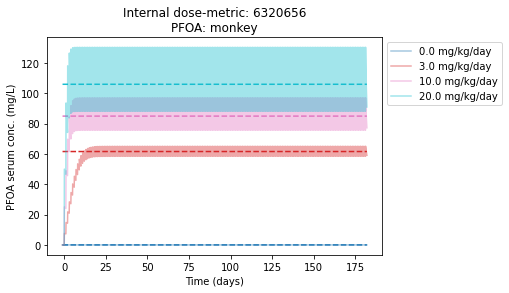

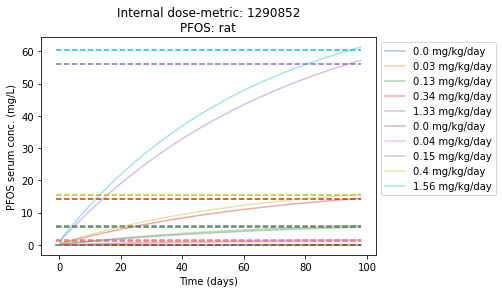

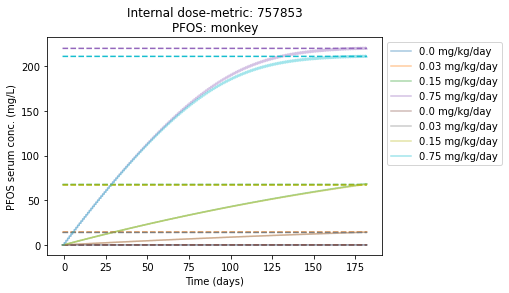

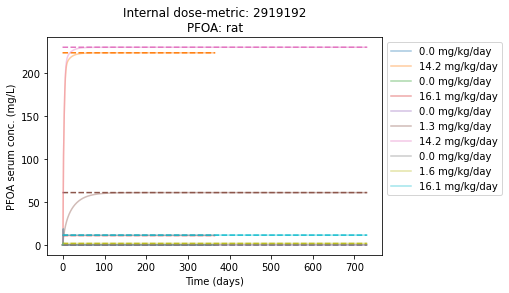

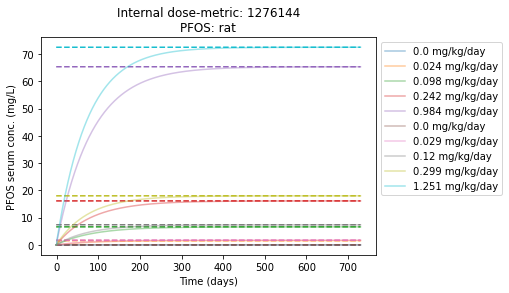

In [9]:
chronic_df = []
for hero_id in chronic_hero_ids:
    print(hero_id)
    study = chronic[chronic['HERO ID'] == hero_id]
    n_doses = len(study['Dose\n(mg/kg-day)'])
    PFAS = PFAS_DR()
    my_colors = cm.get_cmap('tab10', n_doses)
    j = 0
    for i, row in study.iterrows():
        dosing_dict = parse_row(row)
        if dosing_dict['chem'] == 'PFOS' and dosing_dict['strain'] == 'C57B6':
            # We don't have PFOS data for C57B6 so assume CD1 for now
            dosing_dict['strain'] = 'CD1'
        #print(dosing_dict)
        #PFAS.dosing_dict = dosing_dict
        #dosing_dict['disp_params'] = True
        PFAS.update_p(**dosing_dict)
        PFAS.run_model()
        PFAS.plot_time_course(color=my_colors.colors[j], disp_mean=True, alpha=0.4, label_style='dose')
        hero_metrics = PFAS.get_internal_dose_metrics(metrics=all_metrics)
        row['AUC (mg*d/L)'] = hero_metrics['AUC']
        row['AUC_avg (mg/L)'] = hero_metrics['AUCavg']
        row['Cmax (mg/L)'] = hero_metrics['Cmax']
        row['Cavg (mg/L)'] = hero_metrics['Cavg']
        row['C last-7 (mg/L)'] = hero_metrics['C7avg']
        
        chronic_df.append(row)
        j+=1
    PFAS.ax[0].set_title('Internal dose-metric: %s\n%s: %s' % (row['HERO ID'], dosing_dict['chem'], dosing_dict['strain']))
chronic_df = pd.concat(chronic_df, axis=1).T

In [9]:
chronic_df.to_excel(writer, sheet_name='chronic')

# Sub-chronic (30-90 days)

Calculate dose metrics for the subchronic studies

In [10]:
subchronic = tox[tox['Study Design'] == 'Subchronic (30-90 days)']
print('Hero IDs to calculate:')
subchronic_hero_ids = subchronic['HERO ID'].unique().tolist()
print(subchronic_hero_ids)

Hero IDs to calculate:
[5381564, 5080641, 3981454, 3981506, 1291118]


5381564
Running adult model for C57B6 with 0.0 mg/kg PFOA
Running adult model for C57B6 with 0.1 mg/kg PFOA
Running adult model for C57B6 with 1.0 mg/kg PFOA
Running adult model for C57B6 with 5.0 mg/kg PFOA
5080641
Running adult model for CD1 with 0.0 mg/kg PFOS
Running adult model for CD1 with 0.3 mg/kg PFOS
Running adult model for CD1 with 3.0 mg/kg PFOS
3981454
Running adult model for CD1 with 0.0 mg/kg PFOS
Running adult model for CD1 with 0.5 mg/kg PFOS
Running adult model for CD1 with 10.0 mg/kg PFOS
3981506
Running adult model for CD1 with 0.0 mg/kg PFOS
Running adult model for CD1 with 2.5 mg/kg PFOS
Running adult model for CD1 with 5.0 mg/kg PFOS
Running adult model for CD1 with 10.0 mg/kg PFOS
1291118
Running adult model for rat with 0.0 mg/kg PFOA
Running adult model for rat with 0.06 mg/kg PFOA
Running adult model for rat with 0.64 mg/kg PFOA
Running adult model for rat with 1.94 mg/kg PFOA
Running adult model for rat with 6.5 mg/kg PFOA


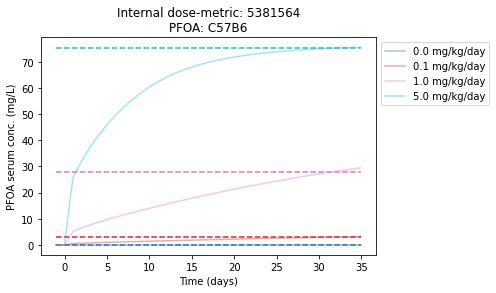

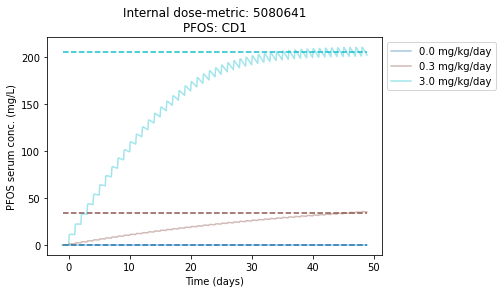

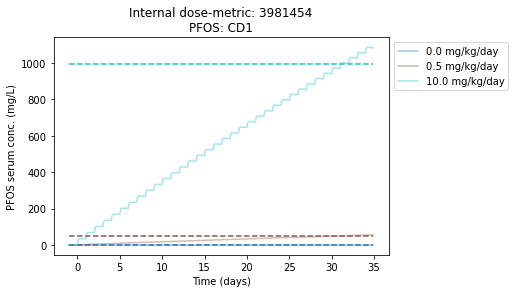

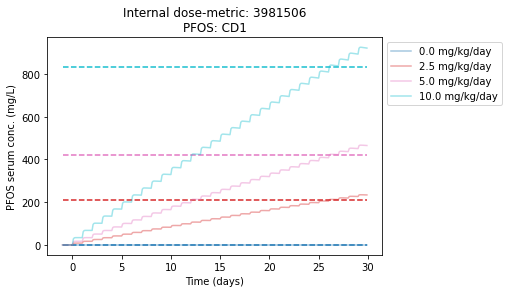

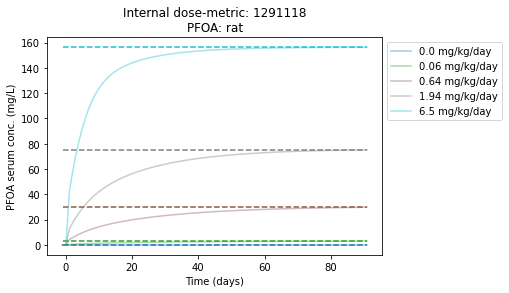

In [11]:
subchronic_df = []
for hero_id in subchronic_hero_ids:
    print(hero_id)
    study = subchronic[subchronic['HERO ID'] == hero_id]
    n_doses = len(study['Dose\n(mg/kg-day)'])
    PFAS = PFAS_DR()
    my_colors = cm.get_cmap('tab10', n_doses)
    j = 0
    for i, row in study.iterrows():
        dosing_dict = parse_row(row)
        if dosing_dict['chem'] == 'PFOS' and dosing_dict['strain'] == 'C57B6':
            # We don't have PFOS data for C57B6 so assume CD1 for now
            dosing_dict['strain'] = 'CD1'
        #PFAS.dosing_dict = dosing_dict
        #dosing_dict['disp_params'] = True
        #print(dosing_dict)
        PFAS.update_p(**dosing_dict)
        PFAS.run_model()
        PFAS.plot_time_course(color=my_colors.colors[j], disp_mean=True, alpha=0.4, label_style='dose')
        hero_metrics = PFAS.get_internal_dose_metrics(metrics=all_metrics)
        row['AUC (mg*d/L)'] = hero_metrics['AUC']
        row['AUC_avg (mg/L)'] = hero_metrics['AUCavg']
        row['Cmax (mg/L)'] = hero_metrics['Cmax']
        row['Cavg (mg/L)'] = hero_metrics['Cavg']
        row['C last-7 (mg/L)'] = hero_metrics['C7avg']
        subchronic_df.append(row)
        j+=1
    PFAS.ax[0].set_title('Internal dose-metric: %s\n%s: %s' % (row['HERO ID'], dosing_dict['chem'], dosing_dict['strain']))
subchronic_df = pd.concat(subchronic_df, axis=1).T

In [12]:
subchronic_df.to_excel(writer, sheet_name='subchronic')

# Short term (<30 days)

Notes:
* Balb/C mice -> CD1 parameters
* ICR mice -> CD1 parameters

In [12]:
short_term = tox[tox['Study Design'] == 'Short-term (1-30 days)']
print('Hero IDs to calculate:')
short_term_hero_ids = short_term['HERO ID'].unique().tolist()
print(short_term_hero_ids)

Hero IDs to calculate:
[5080372, 4355066, 4238554, 4238518, 2848266, 5400977, 5400978, 3981408, 3981583, 3179088, 5079767, 5079802, 3981504, 2851287, 2851199, 3981501, 6505878, 2850230, 1290826, 1290852, 3981487, 3981558, 3981459, 988599]


5080372
Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 0.4 mg/kg PFOA
Running adult model for CD1 with 2.0 mg/kg PFOA
Running adult model for CD1 with 10.0 mg/kg PFOA
4355066
Running adult model for rat with 0.0 mg/kg PFOS
Running adult model for rat with 1.0 mg/kg PFOS
Running adult model for rat with 10.0 mg/kg PFOS
4238554
Running adult model for rat with 0.0 mg/kg PFOS
Running adult model for rat with 1.0 mg/kg PFOS
Running adult model for rat with 10.0 mg/kg PFOS
4238518
Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 0.05 mg/kg PFOA
Running adult model for CD1 with 0.5 mg/kg PFOA
Running adult model for CD1 with 2.5 mg/kg PFOA
Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 0.05 mg/kg PFOA
Running adult model for CD1 with 0.5 mg/kg PFOA
Running adult model for CD1 with 2.5 mg/kg PFOA
2848266
Running adult model for rat with 0.0 mg/kg PFOS
Running adult model for rat with 0.5 mg/kg 

..\PFAS_DR.py:319: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(1,1)


Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 0.31 mg/kg PFOA
Running adult model for CD1 with 1.25 mg/kg PFOA
Running adult model for CD1 with 5.0 mg/kg PFOA
Running adult model for CD1 with 20.0 mg/kg PFOA
1290826
Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 3.75 mg/kg PFOA
Running adult model for CD1 with 7.5 mg/kg PFOA
Running adult model for CD1 with 15.0 mg/kg PFOA
Running adult model for CD1 with 30.0 mg/kg PFOA
Running adult model for CD1 with 0.0 mg/kg PFOA
Running adult model for CD1 with 0.94 mg/kg PFOA
Running adult model for CD1 with 1.88 mg/kg PFOA
Running adult model for CD1 with 3.75 mg/kg PFOA
Running adult model for CD1 with 7.5 mg/kg PFOA
Running adult model for C57B6 with 0.0 mg/kg PFOA
Running adult model for C57B6 with 30.0 mg/kg PFOA
Running adult model for C57B6 with 0.0 mg/kg PFOA
Running adult model for C57B6 with 30.0 mg/kg PFOA
1290852
Running adult model for rat with 0.0 mg/kg PFOS
Runni

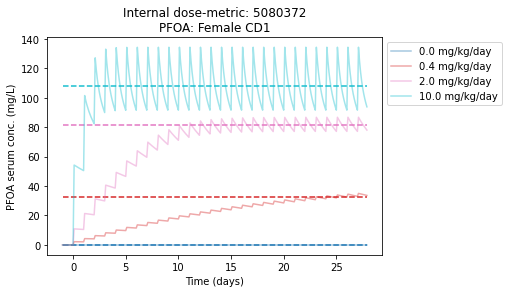

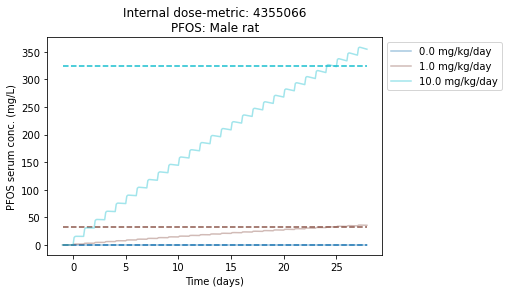

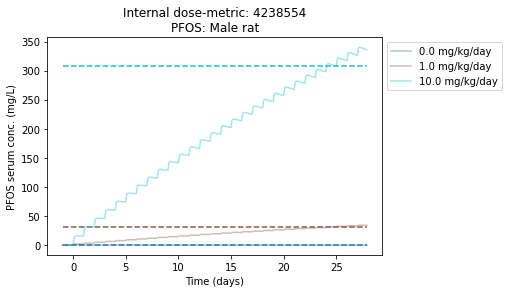

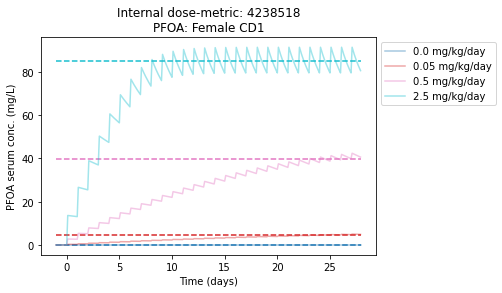

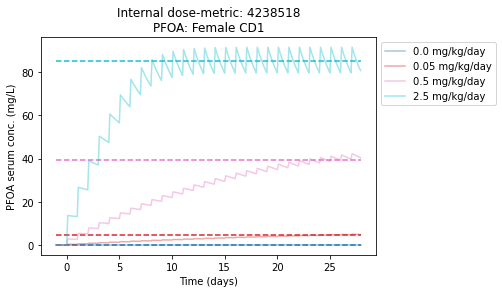

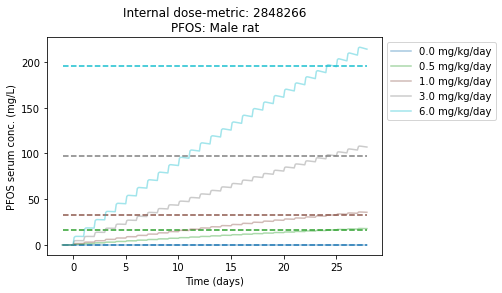

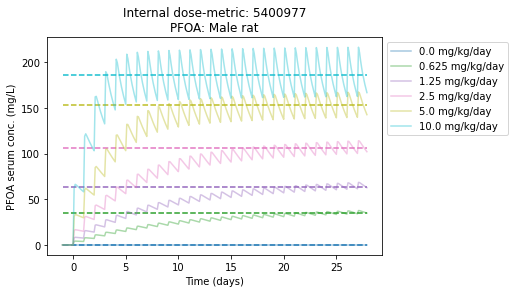

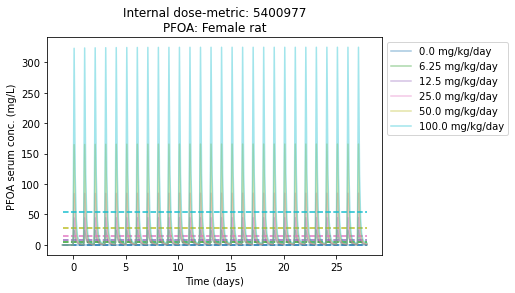

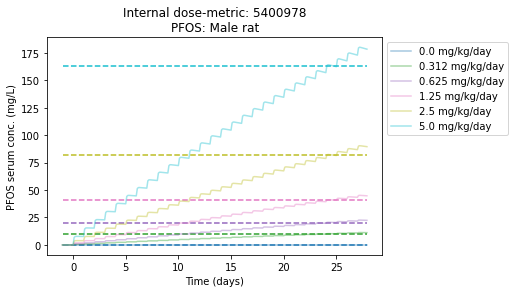

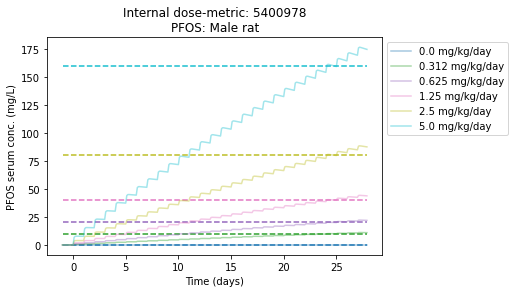

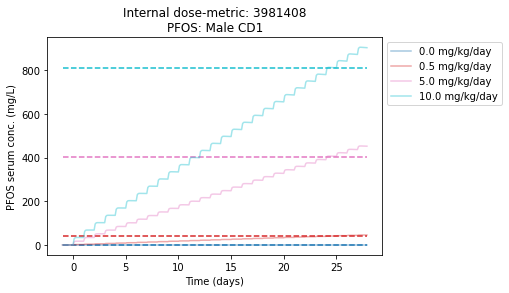

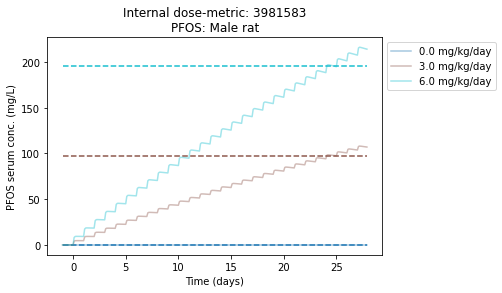

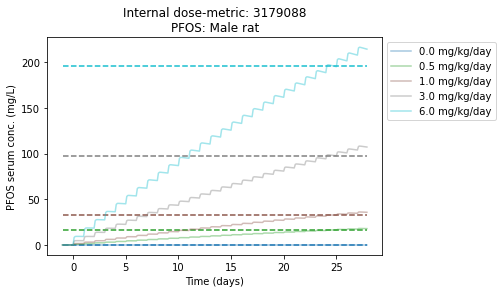

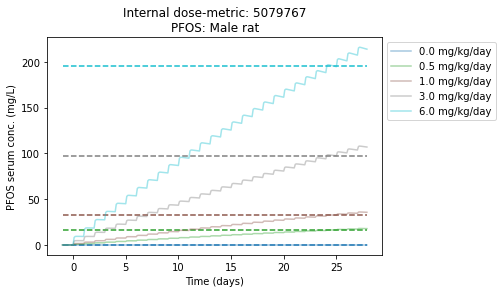

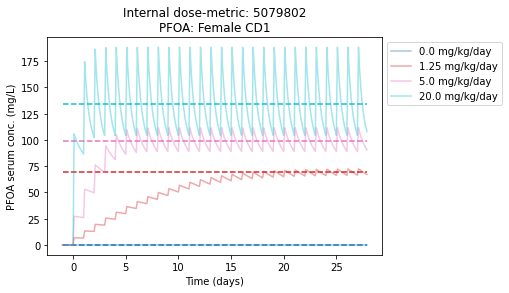

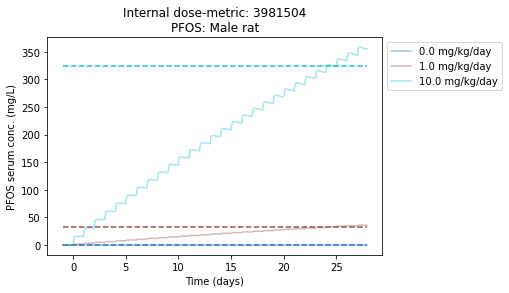

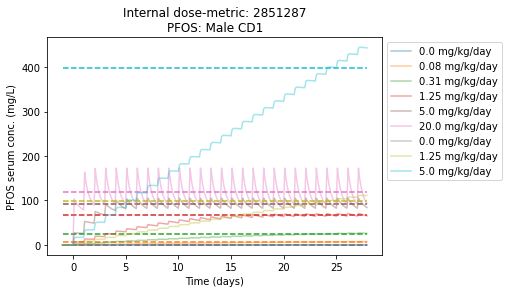

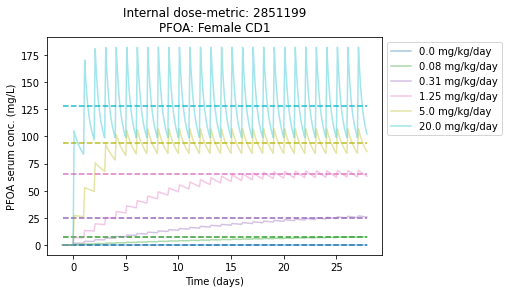

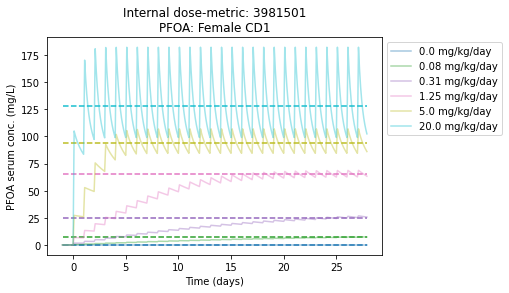

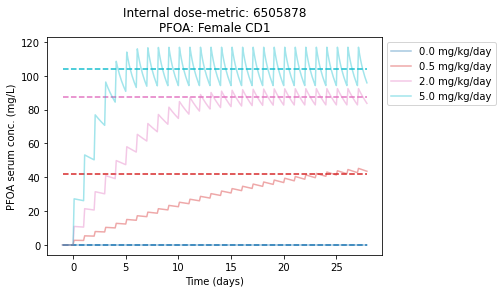

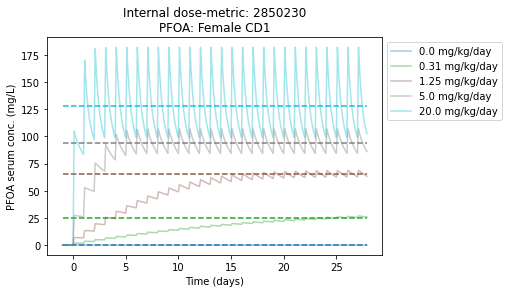

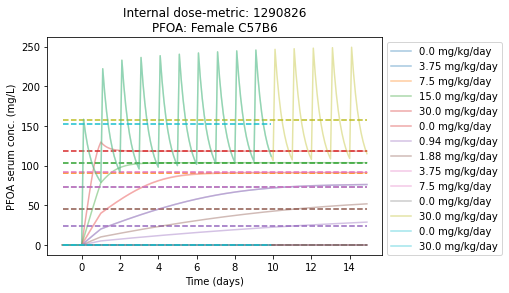

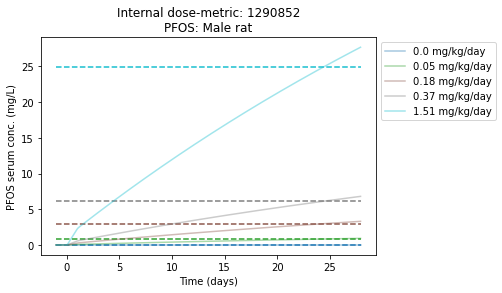

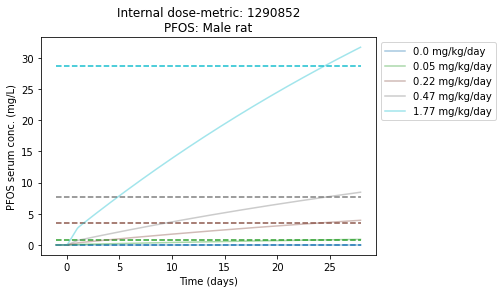

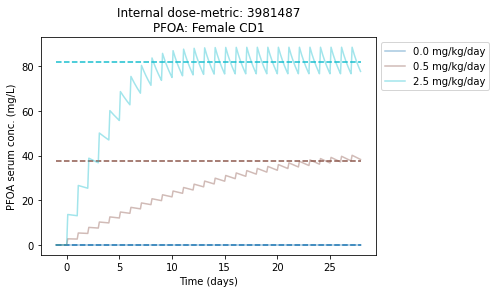

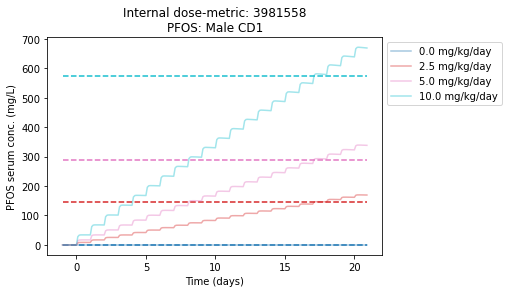

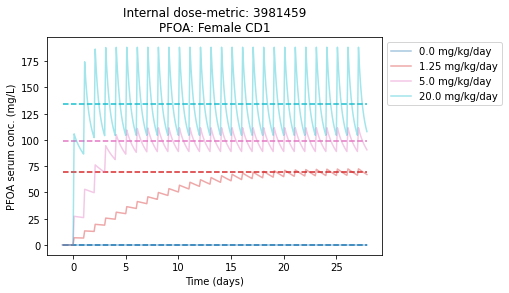

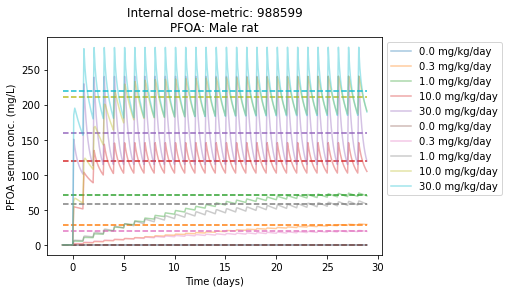

In [13]:
short_term_df = []
for hero_id in short_term_hero_ids:
    print(hero_id)
    tmp_study = short_term[short_term['HERO ID'] == hero_id]
    sex = tmp_study['Sex'].unique()
    for s in sex:
        study = tmp_study[tmp_study['Sex'] == s]
        n_doses = len(study['Dose\n(mg/kg-day)'])
        PFAS = PFAS_DR()
        my_colors = cm.get_cmap('tab10', n_doses)
        j = 0
        for i, row in study.iterrows():
            dosing_dict = parse_row(row)
            if dosing_dict['chem'] == 'PFOA' and dosing_dict['sex'] == 'Male' and dosing_dict['strain'] == 'CD1':
                print('No parameters for PFOA in Male CD1 Mice')
                continue

            if dosing_dict['chem'] == 'PFOS' and dosing_dict['strain'] == 'C57B6':
                # We don't have PFOS data for C57B6 so assume CD1 for now
                dosing_dict['strain'] = 'CD1'
            #PFAS.dosing_dict = dosing_dict
            #dosing_dict['disp_params'] = True
            PFAS.update_p(**dosing_dict)
            PFAS.run_model()
            PFAS.plot_time_course(color=my_colors.colors[j], disp_mean=True, alpha=0.4, label_style='dose')
            hero_metrics = PFAS.get_internal_dose_metrics(metrics=all_metrics)
            row['AUC (mg*d/L)'] = hero_metrics['AUC']
            row['AUC_avg (mg/L)'] = hero_metrics['AUCavg']
            row['Cmax (mg/L)'] = hero_metrics['Cmax']
            row['Cavg (mg/L)'] = hero_metrics['Cavg']
            row['C last-7 (mg/L)'] = hero_metrics['C7avg']
            short_term_df.append(row)
            j+=1
        PFAS.ax[0].set_title('Internal dose-metric: %s\n%s: %s %s' % (row['HERO ID'], dosing_dict['chem'], dosing_dict['sex'],  dosing_dict['strain']))
short_term_df = pd.concat(short_term_df, axis=1).T

In [15]:
short_term_df.to_excel(writer, sheet_name='short_term')

In [16]:
writer.save()